In [ ]:
# Import the machine learning libraries.
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Training parameters.
batch_size = 32
epochs = 100
data_augmentation = True

In [ ]:
# Network parameters.
num_classes = 10
num_dense_blocks = 3
use_max_pool = False

In [ ]:
# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

In [ ]:
# Load the CIFAR10 dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


(100, 32, 32, 3)
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


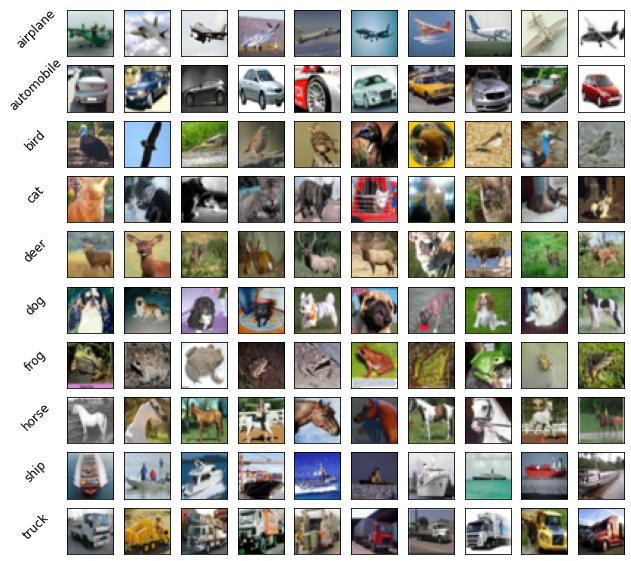

In [ ]:
# Plot randome CIFAR10 images.
class_id = 0
class_count = 0
images = None
for i in range(100):
    while True:
        index = np.random.randint(0, x_train.shape[0], size=1)
        image = x_train[index]
        if y_train[index] == class_id:
            break

    if images is None:
        images = image
    else:
        images = np.concatenate([images, image], axis=0)
    class_count += 1
    if class_count == 10:
        class_id += 1
        class_count = 0
      
print(images.shape)

plt.figure(figsize=(10, 10))
num_images = images.shape[0]
image_size = images.shape[1]
rows = int(math.sqrt(num_images))
row_names = ['{}'.format(row) for row in ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']]
index = 0
for i in range(num_images):
    ax = plt.subplot(rows, rows, i + 1)
    image = images[i, :, :, :]
    image = np.reshape(image, [image_size, image_size, 3])
    plt.imshow(image)
    # plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    if (i % rows) == 0:
        ax.set_ylabel(row_names[index], rotation=45, size='large')
        ax.yaxis.labelpad = 20
        print(row_names[index])
        index += 1

# plt.tight_layout()
plt.show()

In [ ]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [ ]:
# Normalization.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
# Start model definition.
# DenseNet CNNs (composite function) are made of BN-ReLU-Conv2D.
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

In [ ]:
# Stack of dense blocks bridged by transition layers.
for i in range(num_dense_blocks):
    # A dense block is a stack of bottleneck layers.
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # No transition layer after the last dense block.
    if i == num_dense_blocks - 1:
        continue

    # Transition layer compresses num of feature maps and reduces the size by 2.
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)

In [ ]:
# Add classifier on top after average pooling, size of feature map is 1 x 1.
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

In [ ]:
# Instantiate and compile model
# Original paper uses SGD but RMSprop works better for DenseNet.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   672         activation[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/drive/MyDrive/ML_Code/CIFAR10 Classifier'
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
# print(filepath)

In [ ]:
# Prepare callbacks for model saving and for learning rate reducer.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # Preprocessing  and realtime data augmentation.
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    history = model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


    # Fit the model on the batches generated by datagen.flow().
    # history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    #                    steps_per_epoch=x_train.shape[0] // batch_size,
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1,
    #                    callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/100
1563/1563 [==============================] - ETA: 0s - loss: 1.5227 - acc: 0.4483
Epoch 00001: val_acc improved from -inf to 0.54100, saving model to /content/drive/MyDrive/ML_Code/CIFAR10 Classifier/cifar10_densenet_model.01.h5
1563/1563 [==============================] - 185s 118ms/step - loss: 1.5227 - acc: 0.4483 - val_loss: 1.2505 - val_acc: 0.5410
Learning rate:  0.001
Epoch 2/100
1563/1563 [==============================] - ETA: 0s - loss: 1.0203 - acc: 0.6389
Epoch 00002: val_acc improved from 0.54100 to 0.63100, saving model to /content/drive/MyDrive/ML_Code/CIFAR10 Classifier/cifar10_densenet_model.02.h5
1563/1563 [==============================] - 182s 117ms/step - loss: 1.0203 - acc: 0.6389 - val_loss: 1.0882 - val_acc: 0.6310
Learning rate:  0.001
Epoch 3/100
1563/1563 [==============================] - ETA: 0s - loss: 0.7849 - acc: 0.7290
Epoch 00003: val_acc improved from 0.63100 to 0.63300, saving mode

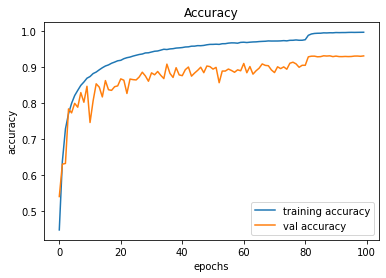

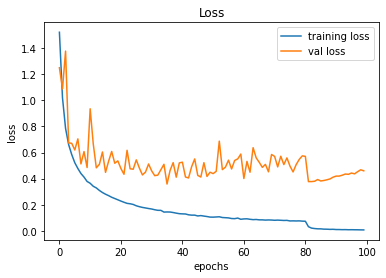

In [ ]:
# Plot graphs for accuracy.
plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.4597860276699066
Test accuracy: 0.9319000244140625


In [ ]:
"""
https://arxiv.org/pdf/1608.06993.pdf
http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
"""

'\nhttps://arxiv.org/pdf/1608.06993.pdf\nhttp://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf\n'